# Train a InceptionResnetV1 to perform DeepFake Detection.

In [1]:
import os
import torch
import torch.utils.data as data_utils
from torch import nn
from torch import optim
from facenet_pytorch import InceptionResnetV1
from tqdm import tqdm
from random import randint
import matplotlib.pyplot as plt
from utils.denormalize_image import denormalize_image
from utils.metrics import get_accuracy
from utils.dict_to_struct import DictStructure
from dataset.faces import Faces

/home/espasa/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {DEVICE.upper()}')

Running on device: CUDA:0


In [3]:
%%capture
!pip install wandb --upgrade

In [4]:
import wandb
wandb.login()

wandb: Currently logged in as: aaronespasa. Use `wandb login --relogin` to force relogin


True

In [5]:
wandb.init(project="deepfake-detection")

### Track metadata & Hyperparameters

In [34]:
config = dict(
    epochs=80,
    save_every=4, # save the model every 2 epochs
    classes=1, # binary classification
    batch_size=32,
    learning_rate=0.001,
    dataset="FaceForensics++",
    architecture="InceptionResNetV1",
    pretrained_dataset="vggface2"
)

### Constants

In [35]:
FACES_FOLDER = os.path.join("data", "faces")
FACES_CSV = os.path.join(FACES_FOLDER, "faces.csv")
VALIDATION_SPLIT = 0.2
CLASS_NAMES = {0: "real", 1: "fake"}

### Create the Data Loaders, the model, the criterion & the optimizer

In [36]:
def make(config):
    """Create the dataloaders, the model, the criterion & the optimizer"""
    if isinstance(config, wandb.Config):
        print("Using the configuration from wandb.config")
    elif isinstance(config, dict):
        print("Not using the configuration from wandb.config")
        config = DictStructure(config)
    else:
        raise ValueError("config must be a wandb.Config or a dict")

    # Make the data
    train_dataset = get_data(split="training", transform=False, print_ds_len=True)
    val_dataset = get_data(split="validation", transform=True, print_ds_len=False)
    train_loader = make_loader(train_dataset, batch_size=config.batch_size)
    val_loader = make_loader(val_dataset, batch_size=config.batch_size)
    
    # Make the model
    model = InceptionResnetV1(
        pretrained=config.pretrained_dataset,
        classify=True,
        num_classes=config.classes,
        device=DEVICE
    )

    # Make the loss and optimizer
    criterion = nn.BCEWithLogitsLoss() # sigmoid + binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    
    return model, train_loader, val_loader, criterion, optimizer

### Data Preparation

In [37]:
def get_data(split:str="training", transform:bool=False, print_ds_len:bool=None):
    """Get the dataset.
    
    Args:
        split (str): Split of the dataset to use: 'training' or 'validation'
        transform (bool, optional): Perform transformations on the data or not
        print_ds_len (bool, optional): Print the length of the original dataset
    """
    # Check that the arguments are as expected
    assert split in ["training", "validation"], "Split must be 'training' or 'validation'"
    assert transform in [True, False], "Transform must be True or False"
    
    # Create the dataset
    full_dataset = Faces(root=FACES_FOLDER, csv=FACES_CSV, split=split, transform=transform)
    if print_ds_len: print(f"Original dataset length: {len(full_dataset)}")

    # Set where the subsets should start and end
    end_idx = round((1 - VALIDATION_SPLIT) * len(full_dataset)) if split == 'training' else len(full_dataset)
    begin_idx = 0 if split == 'training' else round((1 - VALIDATION_SPLIT) * len(full_dataset))

    # Create the subsets
    subset_indices = torch.arange(begin_idx, end_idx)
    subset_dataset = data_utils.Subset(full_dataset, subset_indices)

    print(f"{split} dataset length ({round(len(subset_dataset) / len(full_dataset), 2)*100}%): {len(subset_dataset)}")

    return subset_dataset

In [38]:
def make_loader(dataset, batch_size):
    """Create the Data Loader for the dataset."""
    loader = data_utils.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=2
    )
    return loader

In [39]:
def plot_examples(training_dataset:data_utils.Subset, validation_dataset:data_utils.Subset):
    """Plot some examples of both datasets in subplots"""
    fig, (ax1, ax2) = plt.subplots(1, 2)

    train_image, train_label = training_dataset[randint(0, len(training_dataset)-1)]
    val_image, val_label = validation_dataset[randint(0, len(validation_dataset)-1)]
    train_image, val_image = denormalize_image(train_image), denormalize_image(val_image)

    ax1.set_title(f"Training ({CLASS_NAMES[train_label.int().item()]})")
    ax1.imshow(train_image)
    ax2.set_title(f"Validation ({CLASS_NAMES[val_label.int().item()]})")
    ax2.imshow(val_image)
    plt.show()

Original dataset length: 26402
training dataset length (80.0%): 21122
validation dataset length (20.0%): 5280


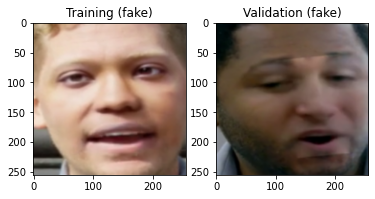

In [45]:
train_dataset = get_data(split="training", transform=False, print_ds_len=True)
val_dataset = get_data(split="validation", transform=True, print_ds_len=False)
plot_examples(train_dataset, val_dataset)

## Training

In [40]:
def train_batch(images, labels, model, criterion, split="training", optimizer=None):
    """Train a batch of data."""
    if split == "training": assert optimizer is not None, "Optimizer must be provided for training"
    assert split in ["training", "validation"], "Split must be 'training' or 'validation'"

    images = images.to(device=DEVICE)
    labels = labels.to(device=DEVICE)

    # Forward pass
    outputs = model(images).squeeze()

    loss = criterion(outputs, labels)
    acc = get_accuracy(outputs, labels)

    if split == "training":
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item(), acc

### Overfit a single batch to see if it's learning something

In [29]:
def overfit_single_batch():
    """Train just a batch to see if the model learns anything"""
    model, _, val_loader, criterion, optimizer = make(config)

    print("Assigning to image & label just one batch of data")
    image, label = None, None
    for images, labels in val_loader:
        image, label = images, labels
        break

    image = image.to(device=DEVICE)
    label = label.to(device=DEVICE)

    print(f"Image shape: {image.shape}")
    print(f"First 10 labels: {label[:10]}")

    total_acc = 0
    epoch_divisions = 2
    num_epochs = epoch_divisions*4
    for epoch in range(num_epochs):
        loss, acc = train_batch(image, label, model, criterion, "training", optimizer)

        total_acc += acc

        if (epoch + 1) % epoch_divisions == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss:.4f}, Acc: {((total_acc/epoch_divisions) * 100):.2f}%')
            total_acc = 0


In [16]:
overfit_single_batch()

Not using the configuration from wandb.config
Original dataset length: 26402
training dataset length (80.0%): 21122
validation dataset length (20.0%): 5280
Assigning to image & label just one batch of data
Image shape: torch.Size([32, 3, 256, 256])
First 10 labels: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Epoch [2/8], Loss: 0.6545, Acc: 54.69%
Epoch [4/8], Loss: 0.4964, Acc: 70.31%
Epoch [6/8], Loss: 0.0681, Acc: 100.00%
Epoch [8/8], Loss: 0.0367, Acc: 100.00%


As we see in the result below, the loss is decreasing.

### Train the model

In [41]:
def model_pipeline(hyperparameters):
    # tell wandb to get started
    with wandb.init(project="deepfake-detection", entity="aaronespasa", config=hyperparameters):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, val_loader, criterion, optimizer = make(config)

      # and use them to train the model
      train(model, train_loader, val_loader, criterion, optimizer, config)

    return model

In [42]:
def save_model(model, optimizer, loss, base_path, epoch):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'validation_loss': loss,
        },
        f"{base_path}_epoch_{epoch}.pth"
    )

In [43]:
def train(model, train_loader, val_loader, criterion, optimizer, config):
    """Train the model and save the information on Weights and Biases."""
    print("Beginning training 🎨")
    wandb.watch(model, criterion, log="all", log_freq=10)

    history = {
        "loss": {"train": [], "val": []},
        "acc": {"train": [], "val": []}
    }
    batches_seen = 0
    base_path = "./models/resnetinceptionv1"

    for epoch in range(config.epochs):
        # Training
        acc_per_epoch_train, loss_per_epoch_train = 0, 0
        model.train()
        for _, (images_batch, labels_batch) in enumerate(tqdm(train_loader)):
            loss, acc = train_batch(images_batch, labels_batch, model, criterion, "training", optimizer)

            batches_seen += 1
            acc_per_epoch_train += acc
            loss_per_epoch_train += loss
        
        # Validation
        with torch.no_grad():
            acc_per_epoch_val, loss_per_epoch_val = 0, 0
            model.eval()
            for _, (images_batch, labels_batch) in enumerate(tqdm(val_loader)):
                loss, acc = train_batch(images_batch, labels_batch, model, criterion, "validation")

                acc_per_epoch_val += acc
                loss_per_epoch_val += loss

        history["loss"]["train"].append(loss_per_epoch_train / len(train_loader))
        history["loss"]["val"].append(loss_per_epoch_val / len(val_loader))
        history["acc"]["train"].append(acc_per_epoch_train / len(train_loader))
        history["acc"]["val"].append(acc_per_epoch_val / len(val_loader))

        print(f"Epoch [{epoch + 1}/{config.epochs}]")
        print(f"\tTrain Loss: {history['loss']['train'][epoch]:.4f}, Train Acc: {history['acc']['train'][epoch]*100:.2f}%")
        print(f"\tVal Loss: {history['loss']['val'][epoch]:.4f}, Val Acc: {history['acc']['val'][epoch]*100:.2f}%", end="\n\n")

        wandb.log({
            "Epoch": epoch + 1,
            "Train Loss": history["loss"]["train"][epoch],
            "Val Loss": history["loss"]["val"][epoch],
            "Train Acc": round(history["acc"]["train"][epoch] * 100, 2),
            "Val Acc": round(history["acc"]["val"][epoch]*100, 2)
        }, step=batches_seen)
        
        if (epoch + 1) % config.save_every == 0:
            save_model(model, optimizer, history["loss"]["val"][epoch], base_path, epoch + 1)

In [ ]:
model = model_pipeline(config)

Using the configuration from wandb.config
Original dataset length: 26402
training dataset length (80.0%): 21122
validation dataset length (20.0%): 5280
Beginning training 🎨


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:40<00:00,  4.09it/s]


Epoch [1/80]
	Train Loss: 0.3277, Train Acc: 86.34%
	Val Loss: 0.2282, Val Acc: 91.31%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:41<00:00,  4.01it/s]


Epoch [2/80]
	Train Loss: 0.2110, Train Acc: 91.53%
	Val Loss: 1.2714, Val Acc: 90.93%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:40<00:00,  4.04it/s]


Epoch [3/80]
	Train Loss: 0.2139, Train Acc: 91.90%
	Val Loss: 0.7442, Val Acc: 67.58%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:41<00:00,  3.95it/s]


Epoch [4/80]
	Train Loss: 0.2023, Train Acc: 91.96%
	Val Loss: 0.1552, Val Acc: 93.90%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:42<00:00,  3.87it/s]


Epoch [5/80]
	Train Loss: 0.1866, Train Acc: 92.82%
	Val Loss: 0.1642, Val Acc: 92.80%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:42<00:00,  3.90it/s]


Epoch [6/80]
	Train Loss: 0.1805, Train Acc: 92.83%
	Val Loss: 0.4028, Val Acc: 84.09%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:42<00:00,  3.91it/s]


Epoch [7/80]
	Train Loss: 0.1686, Train Acc: 93.27%
	Val Loss: 0.1364, Val Acc: 94.75%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:42<00:00,  3.91it/s]


Epoch [8/80]
	Train Loss: 0.1711, Train Acc: 93.45%
	Val Loss: 0.1590, Val Acc: 93.26%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:42<00:00,  3.91it/s]


Epoch [9/80]
	Train Loss: 0.1671, Train Acc: 93.48%
	Val Loss: 0.2234, Val Acc: 90.78%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:42<00:00,  3.86it/s]


Epoch [10/80]
	Train Loss: 0.1435, Train Acc: 94.47%
	Val Loss: 0.2196, Val Acc: 90.97%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:41<00:00,  4.00it/s]


Epoch [11/80]
	Train Loss: 0.1254, Train Acc: 94.88%
	Val Loss: 0.1169, Val Acc: 95.68%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:43<00:00,  3.78it/s]


Epoch [12/80]
	Train Loss: 0.1259, Train Acc: 95.15%
	Val Loss: 0.1311, Val Acc: 95.08%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:43<00:00,  3.83it/s]


Epoch [13/80]
	Train Loss: 0.1052, Train Acc: 95.95%
	Val Loss: 0.2602, Val Acc: 91.14%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:43<00:00,  3.79it/s]


Epoch [14/80]
	Train Loss: 0.1109, Train Acc: 95.84%
	Val Loss: 0.1788, Val Acc: 94.15%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:44<00:00,  3.72it/s]


Epoch [15/80]
	Train Loss: 0.0945, Train Acc: 96.20%
	Val Loss: 0.1231, Val Acc: 95.28%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:44<00:00,  3.74it/s]


Epoch [16/80]
	Train Loss: 0.0905, Train Acc: 96.49%
	Val Loss: 0.1464, Val Acc: 94.32%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:43<00:00,  3.82it/s]


Epoch [17/80]
	Train Loss: 0.0882, Train Acc: 96.84%
	Val Loss: 0.1086, Val Acc: 95.95%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:44<00:00,  3.71it/s]


Epoch [18/80]
	Train Loss: 0.0792, Train Acc: 97.00%
	Val Loss: 0.1132, Val Acc: 95.83%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:42<00:00,  3.86it/s]


Epoch [19/80]
	Train Loss: 0.0712, Train Acc: 97.27%
	Val Loss: 0.1163, Val Acc: 95.81%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:45<00:00,  3.63it/s]


Epoch [20/80]
	Train Loss: 0.0521, Train Acc: 98.12%
	Val Loss: 0.1346, Val Acc: 95.91%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:42<00:00,  3.86it/s]


Epoch [21/80]
	Train Loss: 0.0511, Train Acc: 98.09%
	Val Loss: 0.1329, Val Acc: 95.83%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:45<00:00,  3.65it/s]


Epoch [22/80]
	Train Loss: 0.0423, Train Acc: 98.36%
	Val Loss: 0.3381, Val Acc: 89.45%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:44<00:00,  3.71it/s]


Epoch [23/80]
	Train Loss: 0.0433, Train Acc: 98.32%
	Val Loss: 0.1233, Val Acc: 95.81%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:45<00:00,  3.66it/s]


Epoch [24/80]
	Train Loss: 0.0408, Train Acc: 98.76%
	Val Loss: 0.1225, Val Acc: 95.87%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:45<00:00,  3.63it/s]


Epoch [25/80]
	Train Loss: 0.0352, Train Acc: 98.94%
	Val Loss: 0.2680, Val Acc: 94.11%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:44<00:00,  3.69it/s]


Epoch [26/80]
	Train Loss: 0.0411, Train Acc: 98.69%
	Val Loss: 0.1704, Val Acc: 95.81%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:46<00:00,  3.54it/s]


Epoch [27/80]
	Train Loss: 0.0257, Train Acc: 99.12%
	Val Loss: 0.1780, Val Acc: 94.89%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:46<00:00,  3.56it/s]


Epoch [28/80]
	Train Loss: 0.0259, Train Acc: 99.03%
	Val Loss: 0.1338, Val Acc: 96.48%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:45<00:00,  3.62it/s]


Epoch [29/80]
	Train Loss: 0.0322, Train Acc: 99.04%
	Val Loss: 0.2073, Val Acc: 94.15%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:45<00:00,  3.64it/s]


Epoch [30/80]
	Train Loss: 0.0217, Train Acc: 99.21%
	Val Loss: 0.1304, Val Acc: 96.12%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:46<00:00,  3.57it/s]


Epoch [31/80]
	Train Loss: 0.0204, Train Acc: 99.28%
	Val Loss: 0.1435, Val Acc: 96.57%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:45<00:00,  3.66it/s]


Epoch [32/80]
	Train Loss: 0.0235, Train Acc: 99.18%
	Val Loss: 0.1255, Val Acc: 96.70%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:44<00:00,  3.70it/s]


Epoch [33/80]
	Train Loss: 0.0175, Train Acc: 99.33%
	Val Loss: 0.2252, Val Acc: 95.13%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:45<00:00,  3.60it/s]


Epoch [34/80]
	Train Loss: 0.0163, Train Acc: 99.43%
	Val Loss: 0.2064, Val Acc: 94.85%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:45<00:00,  3.63it/s]


Epoch [35/80]
	Train Loss: 0.0143, Train Acc: 99.50%
	Val Loss: 0.1305, Val Acc: 97.22%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:44<00:00,  3.71it/s]


Epoch [36/80]
	Train Loss: 0.0175, Train Acc: 99.32%
	Val Loss: 0.2886, Val Acc: 93.30%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:50<00:00,  3.28it/s]


Epoch [37/80]
	Train Loss: 0.0130, Train Acc: 99.53%
	Val Loss: 0.2127, Val Acc: 94.17%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:48<00:00,  3.42it/s]


Epoch [38/80]
	Train Loss: 0.1627, Train Acc: 93.57%
	Val Loss: 0.1220, Val Acc: 95.21%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:51<00:00,  3.22it/s]


Epoch [39/80]
	Train Loss: 0.0612, Train Acc: 97.78%
	Val Loss: 0.1210, Val Acc: 96.12%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:47<00:00,  3.44it/s]


Epoch [40/80]
	Train Loss: 0.0260, Train Acc: 99.00%
	Val Loss: 0.1378, Val Acc: 96.33%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:45<00:00,  3.59it/s]


Epoch [41/80]
	Train Loss: 0.0142, Train Acc: 99.46%
	Val Loss: 0.1491, Val Acc: 96.55%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:49<00:00,  3.32it/s]


Epoch [42/80]
	Train Loss: 0.0083, Train Acc: 99.72%
	Val Loss: 0.1882, Val Acc: 96.52%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:45<00:00,  3.64it/s]


Epoch [43/80]
	Train Loss: 0.0073, Train Acc: 99.75%
	Val Loss: 0.1952, Val Acc: 96.40%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:47<00:00,  3.49it/s]


Epoch [44/80]
	Train Loss: 0.0091, Train Acc: 99.71%
	Val Loss: 0.1665, Val Acc: 96.57%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:49<00:00,  3.33it/s]


Epoch [45/80]
	Train Loss: 0.0088, Train Acc: 99.73%
	Val Loss: 0.1309, Val Acc: 96.67%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:49<00:00,  3.33it/s]


Epoch [46/80]
	Train Loss: 0.0067, Train Acc: 99.79%
	Val Loss: 0.1900, Val Acc: 96.34%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:49<00:00,  3.34it/s]


Epoch [47/80]
	Train Loss: 0.0090, Train Acc: 99.73%
	Val Loss: 0.1821, Val Acc: 96.00%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:47<00:00,  3.47it/s]


Epoch [48/80]
	Train Loss: 0.0100, Train Acc: 99.67%
	Val Loss: 0.1487, Val Acc: 96.31%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:46<00:00,  3.52it/s]


Epoch [49/80]
	Train Loss: 0.0100, Train Acc: 99.69%
	Val Loss: 0.1520, Val Acc: 96.33%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:48<00:00,  3.42it/s]


Epoch [50/80]
	Train Loss: 0.0097, Train Acc: 99.65%
	Val Loss: 0.1743, Val Acc: 95.98%



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:47<00:00,  3.44it/s]


Epoch [51/80]
	Train Loss: 0.0093, Train Acc: 99.66%
	Val Loss: 0.2007, Val Acc: 95.40%



 55%|██████████████████████████████████████████████████████▌                                            | 364/661 [05:37<04:43,  1.05it/s]